In [48]:
import pandas as pd
import matplotlib.pyplot as plt

In [75]:
ex_rates = pd.read_csv("CardON/ex_rates.csv")
payments_1 = pd.read_csv("CardON/payments_1.csv")
payments_2 = pd.read_csv("CardON/payments_2.csv")
providers_1 = pd.read_csv("CardON/providers_1.csv")
providers_2 = pd.read_csv("CardON/providers_2.csv")
providers = pd.concat([providers_1,providers_2]).sort_values(by="TIME").reset_index(drop=True)
payments = pd.concat([payments_1,payments_2]).sort_values(by="eventTimeRes").reset_index(drop=True)


providers.to_csv("providers.csv", index=False)
payments.to_csv("payments.csv", index=False)

In [65]:
print(len(ex_rates))
print(len(payments_1))
print(len(payments_2))
print(len(providers_1))
print(len(providers_2))


22
193978
199054
511
426


In [66]:
ex_rates.head(10)

,rate,destination
0,0.586865,AZN
1,1.041829,EUR
2,0.128461,HKD
3,0.000712,KRW
4,0.650000,AUD
5,0.048951,MXN
6,0.263785,PEN
7,0.009587,RUB
8,0.172383,BRL
9,0.006461,JPY


In [77]:
payments.head(10)

,eventTimeRes,amount,cur,payment,cardToken
0,2024-11-24 21:00:00,700.000,RUB,c77be33e8db2f5352ebbc0a1b3f10e3e,336d5ebc5436534e61d16e63ddfca327
1,2024-11-24 21:00:01,180.000,BRL,0ab79b6d41d6e887e84ec4a85ea33733,336d5ebc5436534e61d16e63ddfca327
2,2024-11-24 21:00:01,945.900,RUB,c9a03cbbe592f930d52416b049bc1d1a,336d5ebc5436534e61d16e63ddfca327
3,2024-11-24 21:00:01,35.000,BRL,90a88e0d5b6bfff12909878f265cc2f4,336d5ebc5436534e61d16e63ddfca327
4,2024-11-24 21:00:01,90.000,BRL,f3adde51de36a39508d11d4bf4a98edc,336d5ebc5436534e61d16e63ddfca327
5,2024-11-24 21:00:01,36.000,BRL,d8a90bf2cc88aa672b30bf1b4959751a,336d5ebc5436534e61d16e63ddfca327
6,2024-11-24 21:00:02,450.000,RUB,86633b59a2ae216abcd0a6b21f772e56,336d5ebc5436534e61d16e63ddfca327
7,2024-11-24 21:00:02,4000.000,KZT,e50f20e6c4958eed3382ec6ebaf301a7,afdb62374eae4ebc3fb40bcbf1014ed2
8,2024-11-24 21:00:02,21000.000,RUB,ac9f2bc1026554667dd8374b0ac3f8e9,336d5ebc5436534e61d16e63ddfca327
9,2024-11-24 21:00:03,6.021,BRL,1ef7e6afe4386d6ca86dcb55759051e8,336d5ebc5436534e61d16e63ddfca327


In [76]:
providers.head(10)

,TIME,ID,CONVERSION,AVG_TIME,MIN_SUM,MAX_SUM,LIMIT_MIN,LIMIT_MAX,LIMIT_BY_CARD,COMMISSION,CURRENCY
0,2024-11-24 21:00:00,0,0.50,18.0,700.0,5500.0,61000.0,12900000.0,-,0.035,UZS
1,2024-11-24 21:00:00,26,0.65,26.0,700.0,6000.0,31000.0,18600000.0,-,0.045,MYR
2,2024-11-24 21:00:00,28,0.65,22.0,200.0,9000.0,61000.0,20900000.0,-,0.045,MYR
3,2024-11-24 21:00:00,29,0.65,14.0,100.0,9000.0,81000.0,14700000.0,-,0.030,USD
4,2024-11-24 21:00:00,30,0.50,8.0,400.0,7000.0,71000.0,31600000.0,-,0.050,USD
5,2024-11-24 21:00:00,31,0.55,28.0,100.0,5500.0,31000.0,7900000.0,-,0.035,USD
6,2024-11-24 21:00:00,32,0.60,26.0,600.0,9000.0,61000.0,12000000.0,-,0.027,USD
7,2024-11-24 21:00:00,33,0.50,10.0,500.0,5500.0,21000.0,7100000.0,-,0.045,USD
8,2024-11-24 21:00:00,34,0.70,14.0,900.0,3000.0,51000.0,36700000.0,-,0.040,GHS
9,2024-11-24 21:00:00,35,0.60,20.0,400.0,8000.0,11000.0,34300000.0,-,0.045,GHS


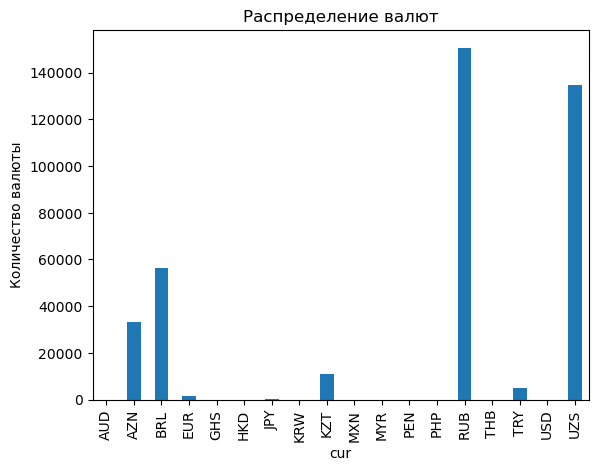

In [78]:
payments["cur"].value_counts().sort_index().plot(kind='bar')
plt.title('Распределение валют')
plt.ylabel('Количество валюты')
plt.show()

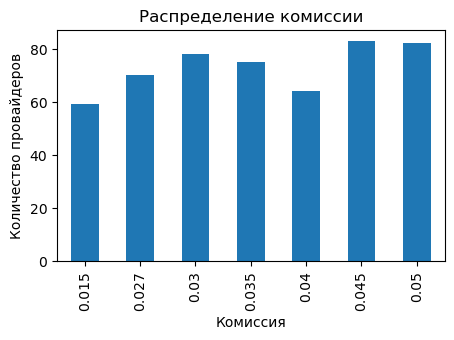

In [57]:
plt.figure(figsize=(5, 3))
[]
providers_1['CONVERSION'].value_counts().sort_index().plot(kind='bar')

plt.title('Распределение комиссии')
plt.xlabel('Комиссия')
plt.ylabel('Количество провайдеров')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 3))

providers_1['COMMISSION'].value_counts().sort_index().plot(kind='bar')

plt.title('Распределение комиссии')
plt.xlabel('Комиссия')
plt.ylabel('Количество провайдеров')
plt.show()

In [39]:
def calculate_provider_score(row, amount, currency, ex_rates):
    """Рассчитывает оценку провайдера на основе различных факторов"""
    score = 0
    if row['CURRENCY'] != currency:
        return -1
    if row['MIN_SUM'] > amount or row['MAX_SUM'] < amount:
        return -1
    
    conversion_score = row['CONVERSION'] * 40
    commission_score = (1 - row['COMMISSION']) * 25
    avg_time_score = max(0, (60 - row['AVG_TIME']) / 60 * 20)
    
    
    if row['LIMIT_MIN'] > 0:
        limit_ratio = payment_amount / row['LIMIT_MIN']
        if limit_ratio > 0.8:  # Если сумма близка к лимиту
            score -= 15

    
    return score
